In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, RFECV
# from sklearn.decomposition import PCAz
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from keras.layers import Bidirectional
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sn
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras import regularizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf

# from grey_wolf_optimizer import grey_wolf_optimizer

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## Dataset

- The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. 

- The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds.

- We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. 

- So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}. 

- The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178 

## The column y contains the category of the 178-dimensional input vector. 

### Specifically y in {1, 2, 3, 4, 5}: 

1. Recording of seizure activity

2. They recorded the EEG from the area where the tumor was located

3. Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

4. eyes closed, means when they were recording the EEG signal the patient had their eyes closed 

5. eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

- All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure.

- Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. 

- Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

## Acknowledgements:

Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907

# Import the data
After getting all the packages we need, lets go for importing the dataset.

In [3]:
dataset = pd.read_csv('Epileptic Seizure Recognition.csv')
dataset.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


The number of trials for the non-seizure class is: 9200
The number of trials for the seizure class is: 2300


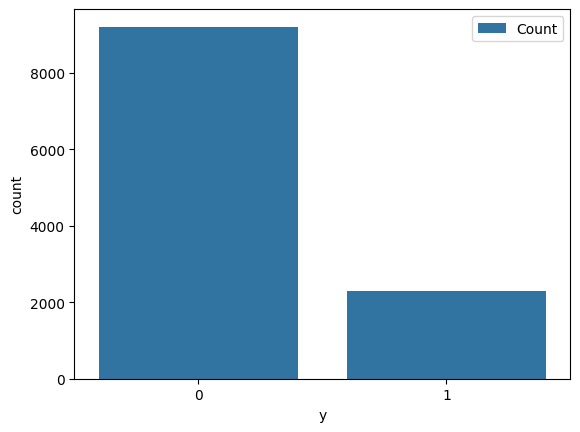

In [4]:
cols = dataset.columns
tgt = dataset.y
tgt[tgt>1]=0
ax = sn.countplot(x=tgt,label="Count")
non_seizure, seizure = tgt.value_counts()
print('The number of trials for the non-seizure class is:', non_seizure)
print('The number of trials for the seizure class is:', seizure)

We classified out target values between 1 and 0 because as we can see taht there are 5 possible classes for the dataset, our main goal being able to correctly identify a seizure, so a binary classification between classes of label 1 and the rest (2,3,4,5) = 0. 

Now lets define dependent and Independent variables to train our model.

In [5]:
X = dataset.iloc[:,1:179].values

X.shape

X[1,:]

array([  386,   382,   356,   331,   320,   315,   307,   272,   244,
         232,   237,   258,   212,     2,  -267,  -605,  -850, -1001,
       -1109, -1090,  -967,  -746,  -464,  -152,   118,   318,   427,
         473,   485,   447,   397,   339,   312,   314,   326,   335,
         332,   324,   310,   312,   309,   309,   303,   297,   295,
         295,   293,   286,   279,   283,   301,   308,   285,   252,
         215,   194,   169,   111,   -74,  -388,  -679,  -892,  -949,
        -972, -1001, -1006,  -949,  -847,  -668,  -432,  -153,    72,
         226,   326,   392,   461,   495,   513,   511,   496,   479,
         453,   440,   427,   414,   399,   385,   385,   404,   432,
         444,   437,   418,   392,   373,   363,   365,   372,   385,
         388,   383,   371,   360,   353,   334,   303,   252,   200,
         153,   151,   143,    48,  -206,  -548,  -859, -1067, -1069,
        -957,  -780,  -597,  -460,  -357,  -276,  -224,  -210,  -350,
        -930, -1413,

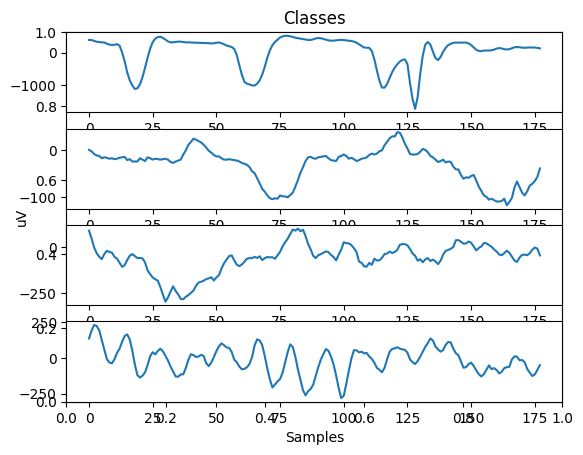

In [6]:
plt.title('Classes')
plt.ylabel('uV')
plt.xlabel('Samples')
plt.subplot(411)
plt.plot(X[1,:])
plt.subplot(412)
plt.plot(X[7,:])
plt.subplot(413)
plt.plot(X[12,:])
plt.subplot(414)
plt.plot(X[0,:])



In [7]:
y = dataset.iloc[:, 179].values
y 

array([0, 1, 0, ..., 0, 0, 0])

To make this a binary problem, let's turn the non-seizure classes 0 while maintaining the seizure as 1.

In [8]:
y[y>1]=0
y

array([0, 1, 0, ..., 0, 0, 0])

Now we split the dataset in a Train Test Split Model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Applying scaling to out independent variables to make easier for our model to converge

# Scaling the data
Formula

$$
z = \frac{(x - \text{{mean}})}{{\text{{standard deviation}}}}
$$
​


In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train[0,0:30]


array([ 0.08211515,  0.0553765 ,  0.06430026,  0.01502536, -0.02991214,
       -0.14542446, -0.27952084, -0.33112469, -0.35154338, -0.36261657,
       -0.37991744, -0.38982207, -0.40464527, -0.42393225, -0.35273282,
       -0.19667786, -0.07032094, -0.0609656 , -0.09429866, -0.10775673,
       -0.03966667,  0.01827295,  0.02723039, -0.0739368 , -0.20441309,
       -0.19603568, -0.12806025, -0.0972802 , -0.13094349, -0.15899873])

In [11]:
y_train[0:30]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0])

Now, we will check the accuracy offered by a simple Logistic Regression Model

# Logistic Regression

In [11]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [12]:
y_pred = classifier.predict(X_test)

In [13]:
accuracies = cross_val_score(estimator = classifier,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             n_jobs = -1)
accuracies.mean()

/home/vybhv/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vybhv/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

0.8185869565217392

# Confusion Matrix

Now, for the predicted y values and the y_test values we will generate a confusion matrix and come up with measurements of Accuracy, Specificity and Precision.


$ {{Accuracy}} = \frac{{\text{{True Positive + True Negatives}}}}{{\text{{Total Number of Predictions}}}} $

${{Specificity}} = \frac{{\text{{True Negatives}}}}{{\text{{True Negatives + False Positives}}}} $

$ {{Precision}} = \frac{{\text{{True Positives}}}}{{\text{{True Positives + False Positives}}}} $



              precision    recall  f1-score   support

 Non-seizure       0.81      1.00      0.89      1829
     Seizure       0.98      0.09      0.16       471

    accuracy                           0.81      2300
   macro avg       0.89      0.54      0.53      2300
weighted avg       0.84      0.81      0.74      2300

Accuracy: 0.8130434782608695
Specificity: 0.9994532531437944
Precision: 0.9767441860465116


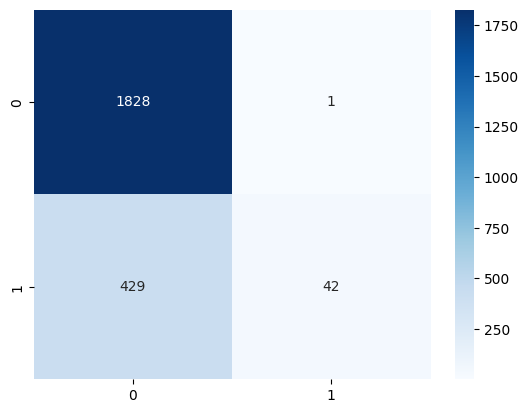

In [14]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['Non-seizure', 'Seizure']))

#00 True Negatives
#01 False Positives
#10 False Negatives
#11 True Positives

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')

accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
print("Accuracy:", accuracy)

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print("Specificity:", specificity)

precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print("Precision:", precision)




With a simple Logistic Regression the classifier was not able to separate the classes in a linear fashion.

Let's try to apply Random Forest with boosting, more specificaly Gradient Boosting, or XGBoost.


# XGBoost

In [15]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
y_pred = clf.predict(X_test)

In [17]:
accuracies = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             n_jobs = -1)
accuracies.mean()

0.9722826086956522

              precision    recall  f1-score   support

 Non-seizure       0.98      0.99      0.98      1829
     Seizure       0.96      0.92      0.94       471

    accuracy                           0.98      2300
   macro avg       0.97      0.95      0.96      2300
weighted avg       0.98      0.98      0.98      2300

Accuracy: 0.9756521739130435
Specificity: 0.9912520503007107
Precision: 0.9642058165548099


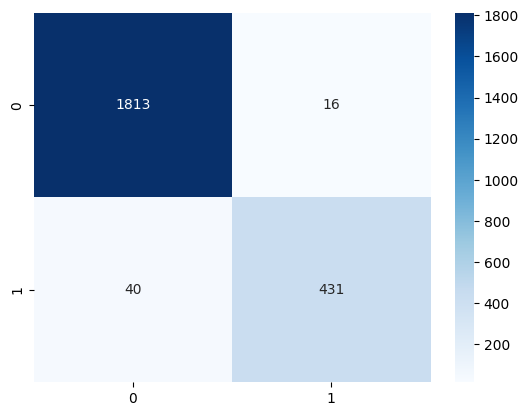

In [18]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')

#00 True Negatives
#01 False Positives
#10 False Negatives
#11 True Positives

accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
print("Accuracy:", accuracy)

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) 
print("Specificity:", specificity)

precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print("Precision:", precision)

# Sooo, all good, yes?

We can see that we are getting good accuracy values for the dataset, but a simple Logistic Model as such should not be able to bring out such great result (then why?), so is there anything wrong going on here??

# Oversampling our seizure class

As we saw in the beginning of this notebook, our classes are imbalanced.

    2300 seizure trials (20%)
    9200 non-seizure trials (80%)

This could lead to a common problem in classification: the accuracy paradox. If our classifier chooses to go all in on the non-seizure class, it still achieves 80% accuracy!

Let's dealt with this problem by using SMOTE(Synthetic Minority Over-sampling Technique) and a Artificial Neural Network

In [12]:
from imblearn.over_sampling import SMOTE
X_s = dataset.iloc[:,1:179].values
y_s = dataset.iloc[:,179].values

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

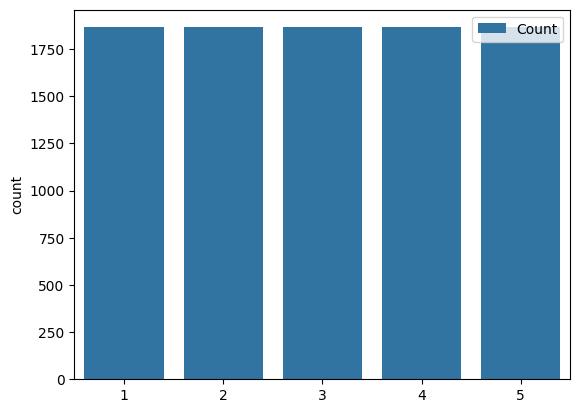

In [13]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s,test_size = 0.2)
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train_s, y_train_s)

# cols = dataset.columns
# tgt = dataset.y
tgt[tgt>1]=0
ax = sn.countplot(x=y_train_res,label="Count")
non_seizure, seizure = y_train_res.value_counts()
print('The number of trials for the non-seizure class is:', non_seizure)
print('The number of trials for the seizure class is:', seizure)

In [22]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc',
                                           min_delta=0,
                                           patience=10,
                                           verbose=1,
                                           mode='max')
clf_ann = Sequential()

clf_ann.add(Dense(activation="relu",
                  kernel_initializer="uniform", 
                  units=100,
                  input_dim=178))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))

clf_ann.add(Dense(activation="relu",
                  kernel_initializer="uniform",
                  units=100))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))

clf_ann.add(Dense(activation="relu",
                  kernel_initializer="uniform",
                  units=100))
clf_ann.add(BatchNormalization())
clf_ann.add(Dropout(0.5))

clf_ann.add(Dense(units=1,
                  kernel_initializer="uniform",
                  activation="sigmoid"))

clf_ann.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

clf_ann.fit(X_train_res, y_train_res,
               batch_size = 32,
               epochs = 100,
               validation_data=(X_test_s,y_test_s),
               callbacks=[early_stop])

Epoch 1/100
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8816 - loss: 0.2887 - val_accuracy: 0.9639 - val_loss: 0.1148
Epoch 2/100
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9339 - loss: 0.1810 - val_accuracy: 0.9665 - val_loss: 0.1032
Epoch 3/100
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9262 - loss: 0.1985 - val_accuracy: 0.9635 - val_loss: 0.1017
Epoch 4/100
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9369 - loss: 0.1766 - val_accuracy: 0.9691 - val_loss: 0.0933
Epoch 5/100
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9384 - loss: 0.1665 - val_accuracy: 0.9652 - val_loss: 0.1034
Epoch 6/100
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9406 - loss: 0.1604 - val_accuracy: 0.9652 - val_loss: 0.0988
Epoch 7/100
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9386 - loss: 0.1652 - val_accuracy: 0.9657 - val_loss: 0.0922
Epoch 8/100
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9405 - loss: 0.1568 - val_accu

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

 Non-seizure       0.99      0.98      0.98      1827
     Seizure       0.92      0.95      0.93       473

    accuracy                           0.97      2300
   macro avg       0.95      0.96      0.96      2300
weighted avg       0.97      0.97      0.97      2300

Accuracy: 0.9721739130434782
Specificity: 0.9781061850027367
Precision: 0.918200408997955


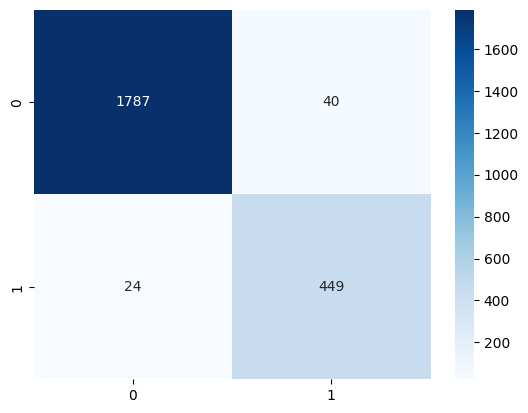

In [23]:
# Predicting the Test set results
y_pred_s = clf_ann.predict(X_test_s)
y_pred_s = (y_pred_s > 0.5)

cm = confusion_matrix(y_test_s, y_pred_s)
print(classification_report(y_test_s, y_pred_s, target_names=['Non-seizure', 'Seizure']))

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')

accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
print("Accuracy:", accuracy)

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print("Specificity:", specificity)

precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print("Precision:", precision)


In [24]:
import numpy as np

# Define harmonic wavelet function
def harmonic_wavelet(t, m, n):
    return np.exp(1j * 2 * np.pi * n * t) - np.exp(1j * 2 * np.pi * m * t)

# Perform HWPT decomposition
def hwpt_decomposition(signal, m, n):
    # Initialize HWPT coefficients
    hwpt_coeffs = []
    
    # Iterate over scaling parameters m and n
    for scale_m in m:
        for scale_n in n:
            # Compute HWPT coefficient for each scale
            hwpt_coef = np.abs(np.sum(signal * np.conj(harmonic_wavelet(np.arange(len(signal)), scale_m, scale_n))))
            hwpt_coeffs.append(hwpt_coef)
    
    return np.array(hwpt_coeffs)

# Compute energy in sub-bands
def compute_energy(hwpt_coeffs, num_subbands):
    # Compute the number of coefficients per sub-band
    coeffs_per_subband = len(hwpt_coeffs) // num_subbands
    
    # Initialize energy values
    energy_values = []
    
    # Compute energy for each sub-band
    for i in range(num_subbands):
        start_idx = i * coeffs_per_subband
        end_idx = (i + 1) * coeffs_per_subband
        subband_energy = np.sum(np.abs(hwpt_coeffs[start_idx:end_idx])**2)
        energy_values.append(subband_energy)
    
    return energy_values

# Extract features using HWPT
def extract_hwpt_features(eeg_signals, m, n, num_subbands):
    hwpt_features = []
    
    # Iterate over EEG signals
    for signal in eeg_signals:
        # Perform HWPT decomposition
        hwpt_coeffs = hwpt_decomposition(signal, m, n)
        
        # Compute energy in sub-bands
        energy_values = compute_energy(hwpt_coeffs, num_subbands)
        
        # Append energy values as features
        hwpt_features.append(energy_values)
    
    return np.array(hwpt_features)

# Example usage:
# Load EEG signals
eeg_signals = X_train # Example EEG signals (10 samples, 1000 data points each)

# Set scaling parameters m and n
m_values = [1, 2, 3]  # Example values for m
n_values = [4, 5, 6]  # Example values for n

# Set the number of sub-bands for decomposition
num_subbands = 5  # Example number of sub-bands

# Extract HWPT features
hwpt_features = extract_hwpt_features(eeg_signals, m_values, n_values, num_subbands)
print(hwpt_features)  # Print shape of the extracted features


[[3.85329219e-24 3.95465186e-24 7.77180808e-24 1.71257431e-24
  1.78036673e-24]
 [2.56978471e-23 4.36903643e-23 7.08779667e-23 1.14212654e-23
  2.42073896e-23]
 [7.15575455e-26 4.87820519e-26 1.23250343e-25 3.18033536e-26
  9.61211226e-26]
 ...
 [1.77553932e-23 2.40829506e-23 1.52700033e-23 7.89128587e-24
  1.22700748e-23]
 [8.20121070e-24 8.63731550e-24 1.99628133e-23 3.64498253e-24
  3.93760185e-24]
 [5.48175822e-24 6.34337411e-24 1.24602495e-23 2.43633699e-24
  3.02122484e-24]]


In [25]:
print(hwpt_features.shape)
print(X_train.shape)

(9200, 5)
(9200, 178)


In [13]:
import numpy as np
import pywt

# Assume your sampling rate is fs (replace with your actual value)
fs = 178  # Example sampling rate (adjust based on your data)

# Wavelet function and decomposition level (adjust if needed)
wavelet_function = 'db1'
decomposition_level = 5

# Assuming the detail coefficients correspond to frequency bands in order
detail_coeffs = coeffs[1]  # Access detail coefficients

# Function to check if the frequency range of the detail coefficient falls within 0-40 Hz
def is_in_range(coeff_index, fs, wavelet_function, decomposition_level):
  # Calculate approximate center frequency of the detail coefficient
  center_freq = fs / (2**decomposition_level) * (coeff_index + 0.5)
  # Check if the center frequency is within the desired range
  return 0 <= center_freq <= 40

features = []
for i in range(len(detail_coeffs)):
  if is_in_range(i, fs, wavelet_function, decomposition_level):
    # Extract features from the detail coefficient with index i
    # Replace with your desired feature calculation (e.g., energy, entropy, etc.)
    energy = np.sum(np.abs(detail_coeffs[i]) ** 2)
    features.append(energy)

# Process the extracted features for further analysis or machine learning
features


[0.00035747775316007216,
 0.0012140078887699047,
 0.006671548482828697,
 0.0013314787630776747,
 6.130775502194621e-05,
 4.9050849476174874e-05,
 0.0001859938269239157]

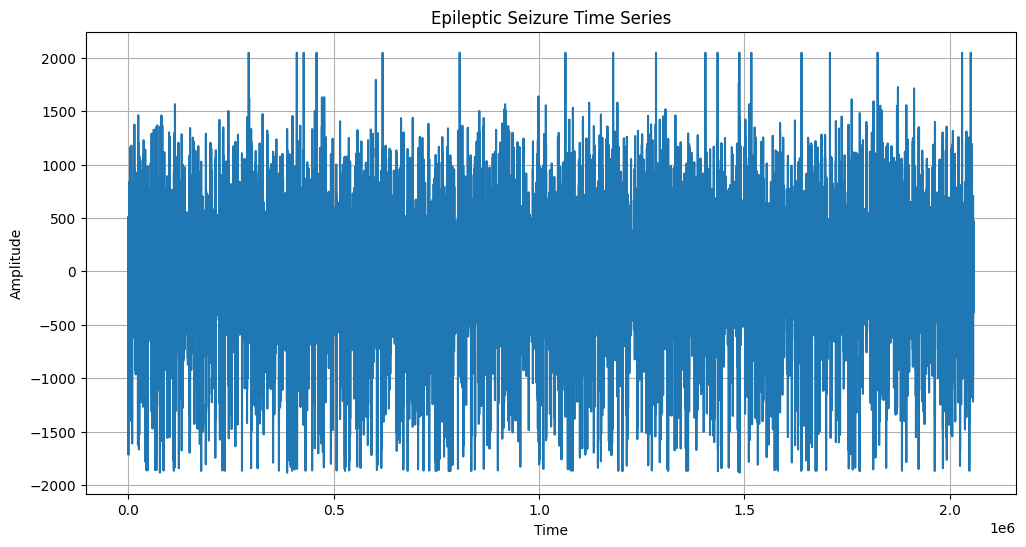

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("Epileptic Seizure Recognition.csv")  # Replace "your_dataset.csv" with the path to your dataset file

# Concatenate all rows
all_data = data.drop(columns=["Unnamed"])  # Adjust column name if necessary
all_data = all_data.values.flatten()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(all_data)
plt.title("Epileptic Seizure Time Series")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


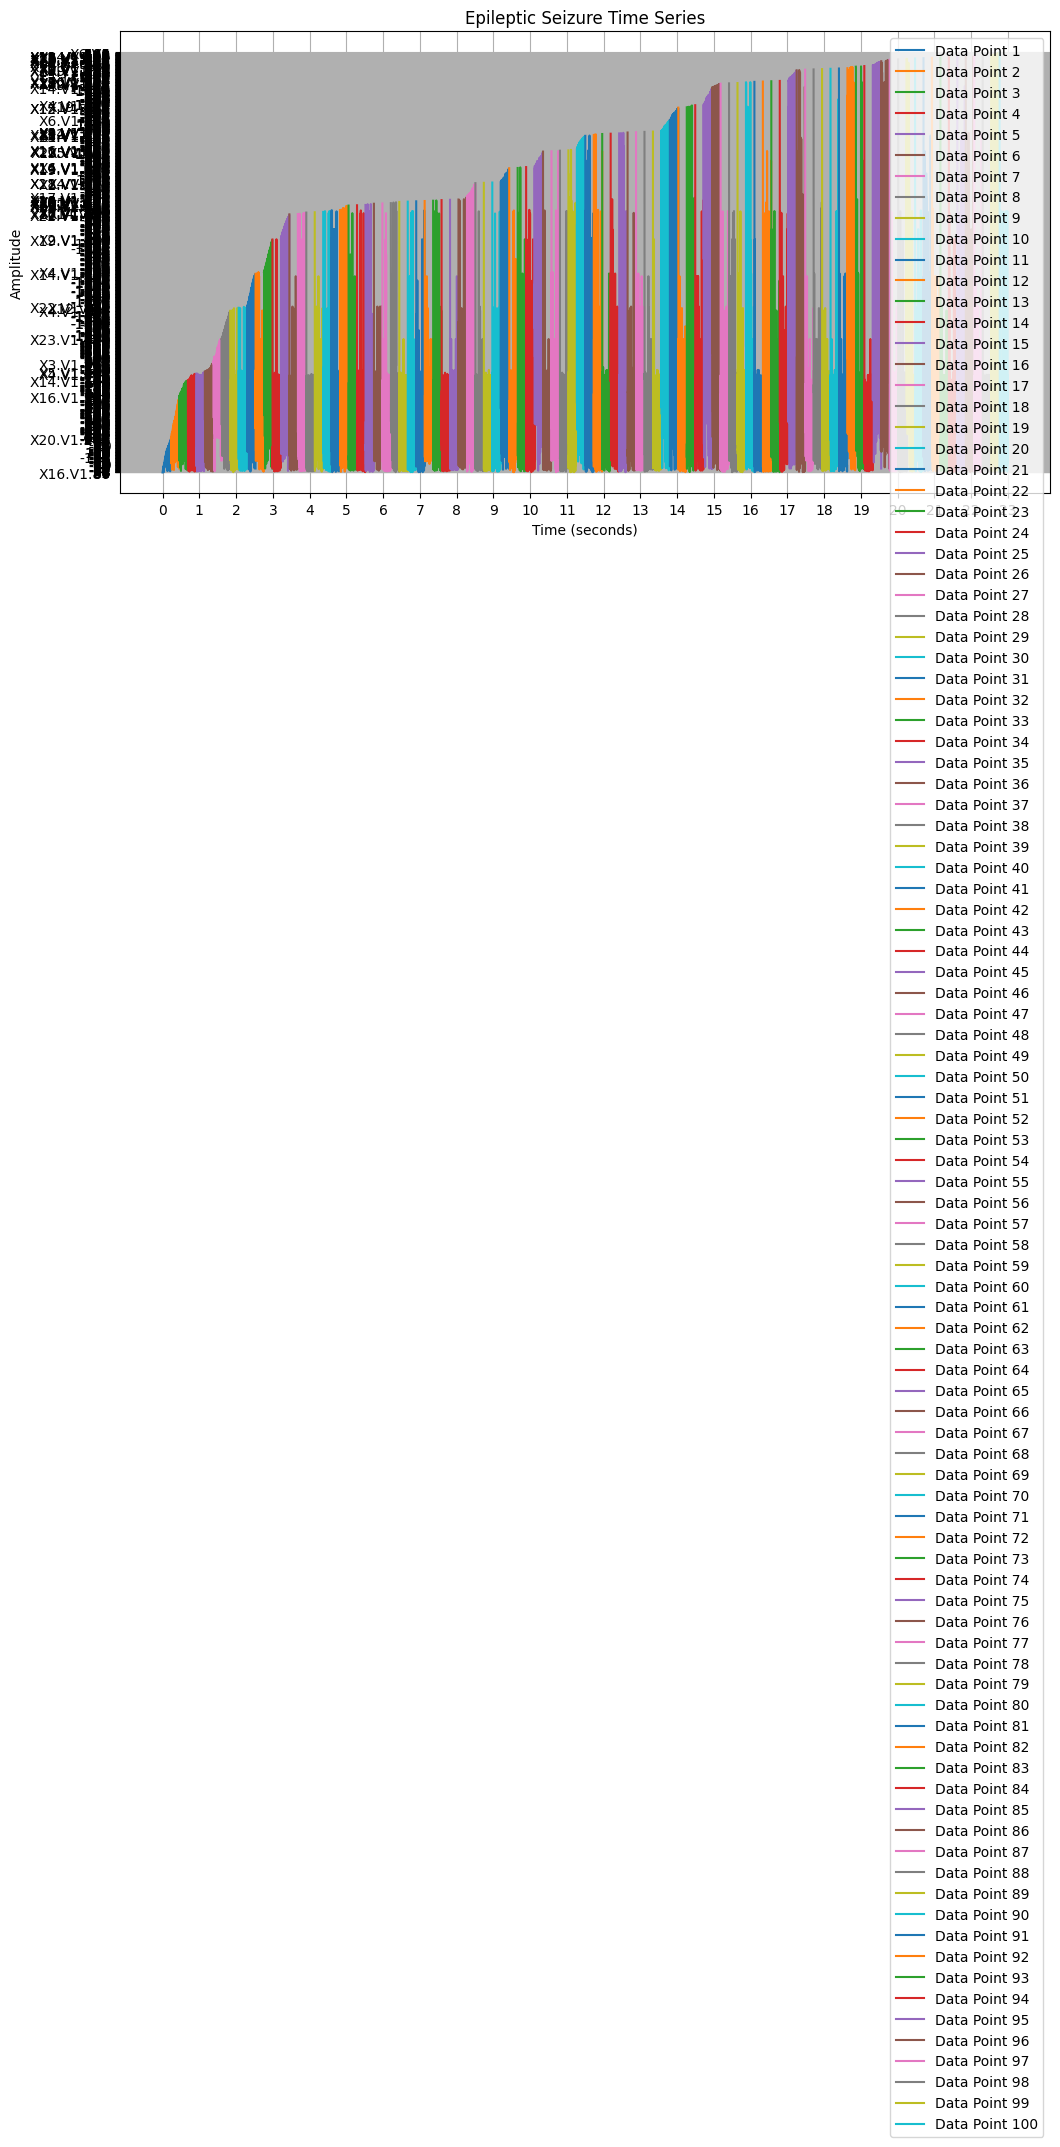

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data = pd.read_csv("Epileptic Seizure Recognition.csv")  # Replace "your_dataset.csv" with the path to your dataset file

# Convert values to strings
data = data.astype(str)

sampled_data = data.sample(n=100)  # Adjust the sample size as needed

# Calculate the total number of data points
num_data_points = len(sampled_data) * len(sampled_data.columns)

# Calculate the x-axis values for the total number of data points
time_values = np.linspace(0, 23, num_data_points)  # Spread time values evenly over 23 seconds

# Plot each row as a separate line
plt.figure(figsize=(12, 6))
for i in range(len(sampled_data)):
    plt.plot(time_values[i*len(sampled_data.columns):(i+1)*len(sampled_data.columns)], sampled_data.iloc[i].values, label=f'Data Point {i+1}')

plt.title("Epileptic Seizure Time Series")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, 24, 1))  # Set x-axis ticks for each second
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import numpy as np
import pandas as pd
import pywt

# Load the dataset
dataset = pd.read_csv("Epileptic Seizure Recognition.csv")#Epileptic Seizure Recognition.csv

# Separate features (X1 to X178) and target variable (y)
# X = dataset.iloc[1:, :-1].values  # Features
# y = dataset.iloc[1:, -1].values   # Target variable
X = dataset.iloc[:,1:179].values
y = dataset.iloc[:, 179].values


# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    # Extract features from each EEG recording using wavelet decomposition
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs):
    features = []
    
    for band in [(1, 4), (4, 8), (8, 13), (13, 30)]:
        band_energy = []
        for coeff in coeffs:
            # Compute energy in the frequency band for each level of decomposition
            band_coeff = np.array(coeff)
            band_coeff = band_coeff[np.where((band_coeff >= band[0]) & (band_coeff <= band[1]))]
            band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features


# Extract features for each EEG recording
extracted_features = [extract_features(coeffs) for coeffs in wavelet_coeffs]

# Convert features to numpy array
extracted_features = np.array(extracted_features)
extracted_features

# Further analysis (classification, etc.) with the extracted features and target variable (y)


array([[[0.00000000e+00, 0.00000000e+00, 1.54120574e+01, 5.60232963e+01],
        [0.00000000e+00, 0.00000000e+00, 1.03871658e+02, 4.54110472e+02],
        [7.24450679e+01, 1.60317571e+02, 3.02680221e+02, 1.44199900e+03],
        [0.00000000e+00, 0.00000000e+00, 2.01723777e+03, 1.54704922e+03]],

       [[0.00000000e+00, 0.00000000e+00, 1.36692542e+01, 6.89604917e+01],
        [0.00000000e+00, 0.00000000e+00, 7.30937660e+01, 4.80000755e+02],
        [0.00000000e+00, 0.00000000e+00, 4.05726436e+02, 3.22704356e+02],
        [0.00000000e+00, 4.64411134e+02, 1.56203000e+03, 2.11377731e+03]],

       [[6.80461800e+00, 1.61747200e+01, 0.00000000e+00, 1.79244011e+02],
        [0.00000000e+00, 6.21667292e+01, 1.24811003e+02, 3.80737437e+02],
        [1.04167553e+02, 1.11760709e+02, 6.99747264e+02, 1.74581642e+02],
        [0.00000000e+00, 9.63513739e+02, 5.36583243e+03, 0.00000000e+00]],

       ...,

       [[2.02656022e+01, 2.76826192e+00, 7.81100752e+00, 2.47644379e+01],
        [1.38170849

In [10]:
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# Load the dataset
dataset = pd.read_csv("Epileptic Seizure Recognition.csv")

# Separate features (X1 to X178) and target variable (y)


# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs):
    features = []
    for band in [(1, 40)]:
        band_energy = []
        for coeff in coeffs:
            band_coeff = np.array(coeff)
            band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
            band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Extract features for each EEG recording
extracted_features = [extract_features(coeffs) for coeffs in wavelet_coeffs]

# Convert features to numpy array
extracted_features = np.array(extracted_features)
print(extracted_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=64))
model.add(Dense(units=5, activation='softmax'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


[[[  72.44506788  160.31757125 6503.23230883 3499.18198084]]

 [[   0.          464.41113424 3126.70413812 2985.44290936]]

 [[ 110.97217062 3406.10147094 8079.58859837  734.56309083]]

 ...

 [[2735.18705579 1146.6587072  9651.58358198 5925.72672433]]

 [[2577.67964822 4294.32092836 3650.41010893  939.37184919]]

 [[2364.47267677 1051.72753801 5923.28008163  658.6654319 ]]]


2024-05-06 19:43:21.510238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2787 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/100


2024-05-06 19:43:24.513178: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6976 - loss: 0.5842 - val_accuracy: 0.9071 - val_loss: 0.4285
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9064 - loss: 0.4158 - val_accuracy: 0.9071 - val_loss: 0.3736
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9032 - loss: 0.3677 - val_accuracy: 0.9082 - val_loss: 0.3390
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9061 - loss: 0.3366 - val_accuracy: 0.9103 - val_loss: 0.3156
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9085 - loss: 0.3128 - val_accuracy: 0.9120 - val_loss: 0.3021
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9066 - loss: 0.2997 - val_accuracy: 0.9065 - val_loss: 0.2895
Epoch 7/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9021 - loss: 0.2927 - val_accuracy: 0.9082 - val_loss: 0.2779
Epoch 8/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8972 - loss: 0.2900 - val_accuracy: 0.8984

In [2]:
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import genetic

# Load the dataset
dataset = pd.read_csv("Epileptic Seizure Recognition.csv")

# Separate features (X1 to X178) and target variable (y)
X = dataset.iloc[:, 1:179].values
y = dataset.iloc[:, 179].values

# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[i][j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the fitness function
def fitness(chromosome):
    # Extract features for each EEG recording based on the chromosome
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    # Reshape input data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=64))
    model.add(Dense(units=5, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    return test_accuracy  # Fitness is based on test accuracy

# Define chromosome length and population size
chromosome_length = len(wavelet_coeffs[0])
population_size = 20

# Create initial population
population = np.random.randint(2, size=(population_size, chromosome_length))

# Initialize genetic algorithm
ga = genetic.GeneticAlgorithm(population, fitness)

# Run genetic algorithm
best_solution = ga.run()

# Extract features based on the best solution
best_features = [extract_features(coeffs, best_solution) for coeffs in wavelet_coeffs]

# Train LSTM model using the best features
# (code to train LSTM model with the best features)


AttributeError: module 'genetic' has no attribute 'GeneticAlgorithm'

In [8]:
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# Load the dataset
dataset = pd.read_csv("Epileptic Seizure Recognition.csv")

# Separate features (X1 to X178) and target variable (y)


# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs):
    features = []
    for band in [(1, 40)]:
        band_energy = []
        for coeff in coeffs:
            band_coeff = np.array(coeff)
            band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
            band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Extract features for each EEG recording
extracted_features = [extract_features(coeffs) for coeffs in wavelet_coeffs]

# Convert features to numpy array
extracted_features = np.array(extracted_features)
print(extracted_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=64))
model.add(Dense(units=5, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


[[[  72.44506788  160.31757125 6503.23230883 3499.18198084]]

 [[   0.          464.41113424 3126.70413812 2985.44290936]]

 [[ 110.97217062 3406.10147094 8079.58859837  734.56309083]]

 ...

 [[2735.18705579 1146.6587072  9651.58358198 5925.72672433]]

 [[2577.67964822 4294.32092836 3650.41010893  939.37184919]]

 [[2364.47267677 1051.72753801 5923.28008163  658.6654319 ]]]
Epoch 1/100


2024-05-06 09:16:12.646512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 09:16:12.804251: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8663 - loss: 0.3467 - val_accuracy: 0.9130 - val_loss: 0.2340
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9108 - loss: 0.2406 - val_accuracy: 0.9158 - val_loss: 0.2281
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9111 - loss: 0.2330 - val_accuracy: 0.9114 - val_loss: 0.2284
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9084 - loss: 0.2373 - val_accuracy: 0.9168 - val_loss: 0.2309
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9150 - loss: 0.2250 - val_accuracy: 0.9185 - val_loss: 0.2316
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9115 - loss: 0.2327 - val_accuracy: 0.9141 - val_loss: 0.2236
Epoch 7/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9158 - loss: 0.2213 - val_accuracy: 0.9168 - val_loss: 0.2241
Epoch 8/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9138 - loss: 0.2233 - val_accuracy: 0.9158

In [9]:
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from geneticalgorithm import geneticalgorithm as ga


# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the fitness function
def fitness(chromosome):
    # Extract features for each EEG recording based on the chromosome
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    # Reshape input data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=64))
    model.add(Dense(units=5, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    return test_accuracy  # Fitness is based on test accuracy

# Define the bounds for the variables
varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

# Define the genetic algorithm
model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound)

# Run the genetic algorithm
model.run()


2024-05-04 05:13:12.044592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-04 05:13:12.045363: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


given function is not applicable


AssertionError: After 10.0 seconds delay func_timeout: the given function does not provide any output

In [9]:
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from geneticalgorithm import geneticalgorithm as ga


# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the fitness function

def fitness(chromosome):
    # Feature selection based on the chromosome
    selected_features = chromosome.tolist()
    selected_coeffs = [coeffs[j] for j, is_selected in enumerate(selected_features) if is_selected]
    
    # Extract features for each EEG recording based on the selected coefficients
    extracted_features = [extract_features(coeffs, selected_features) for coeffs in selected_coeffs]
    extracted_features = np.array(extracted_features)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    # Reshape input data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=32))
    model.add(Dense(units=5, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model with reduced training epochs and batch size
    history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(test_accuracy)
    
    return test_accuracy  # Fitness is based on test accuracy


# Define the bounds for the variables
varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

# Define the genetic algorithm
model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=60)



model.run()


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [13]:
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from geneticalgorithm import geneticalgorithm as ga
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features


# Define the fitness function

def fitness(chromosome):
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    print(extract_features)
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=64))
    model.add(Dense(units=5, activation='softmax'))
    model.add(Dense(units=1,activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                        callbacks=[early_stopping], verbose=0)
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(test_accuracy)
    return test_accuracy  

varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=60)



model.run()


<function extract_features at 0x776af052be20>
0.7986956238746643
<function extract_features at 0x776af052be20>
0.7978261113166809
<function extract_features at 0x776af052be20>
0.843478262424469
<function extract_features at 0x776af052be20>
0.8460869789123535
<function extract_features at 0x776af052be20>


2024-05-05 10:54:45.722246: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at cudnn_rnn_ops.cc:1779 : UNKNOWN: CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
2024-05-05 10:54:45.722279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: UNKNOWN: CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
	 [[{{function_node __inference_one_step_on_data_482871}}{{node sequential_1/lstm_1/CudnnRNNV3}}]]


UnknownError: Graph execution error:

Detected at node sequential_1/lstm_1/CudnnRNNV3 defined at (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1030, in _bootstrap

  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner

  File "/usr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure

  File "/usr/lib/python3.12/threading.py", line 1010, in run

  File "/home/vybhv/.local/lib/python3.12/site-packages/func_timeout/dafunc.py", line 68, in funcwrap

  File "/home/vybhv/.local/lib/python3.12/site-packages/geneticalgorithm/geneticalgorithm.py", line 536, in evaluate

  File "/tmp/ipykernel_11914/2246881925.py", line 60, in fitness

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/models/functional.py", line 202, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/models/functional.py", line 592, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 560, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 527, in inner_loop

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
	 [[{{node sequential_1/lstm_1/CudnnRNNV3}}]] [Op:__inference_one_step_on_iterator_482948]

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from geneticalgorithm import geneticalgorithm as ga

# Check if GPU is available and select the first GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the fitness function
def fitness(chromosome):
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    model = nn.Sequential(
        nn.LSTM(input_size=X_train.shape[2], hidden_size=128, num_layers=1, batch_first=True),
        nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True),
        nn.Linear(64, 5),
        nn.Softmax(dim=1),
        nn.Linear(5, 1),
        nn.Sigmoid()
    ).to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        output, _ = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        output, _ = model(X_test)
        test_loss = criterion(output.squeeze(), y_test)
        predicted = torch.round(output).cpu().numpy()
        accuracy = np.mean(predicted == y_test.cpu().numpy())
        print(accuracy)
        return accuracy

varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=60)

model.run()


AttributeError: 'tuple' object has no attribute 'dim'

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from geneticalgorithm import geneticalgorithm as ga

# Check if GPU is available and select the first GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the fitness function
def fitness(chromosome):
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    # Reshape X_train and X_test
    X_train = X_train.unsqueeze(2)  # Add a dummy dimension for the number of channels
    X_test = X_test.unsqueeze(2)    # Add a dummy dimension for the number of channels
    
    model = nn.Sequential(
        nn.LSTM(input_size=X_train.shape[2], hidden_size=128, num_layers=1, batch_first=True),
        nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True),
        nn.Linear(64, 5),
        nn.Softmax(dim=1),
        nn.Linear(5, 1),
        nn.Sigmoid()
    ).to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        output, _ = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        output, _ = model(X_test)
        test_loss = criterion(output.squeeze(), y_test)
        predicted = torch.round(output).cpu().numpy()
        accuracy = np.mean(predicted == y_test.cpu().numpy())
        print(accuracy)
        return accuracy

varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=60)

model.run()


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from geneticalgorithm import geneticalgorithm as ga

# Check if GPU is available and select the first GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = []
for i in range(len(X)):
    coeffs = pywt.wavedec(X[i], wavelet, level=level)
    wavelet_coeffs.append(coeffs)

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the fitness function
def fitness(chromosome):
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    model = nn.Sequential(
        nn.LSTM(input_size=X_train.shape[2], hidden_size=128, num_layers=1, batch_first=True),
        nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True),
        nn.Linear(64, 5),
        nn.Softmax(),
        nn.Linear(5, 1),
        nn.Sigmoid()
    ).to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        output, _ = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        output, _ = model(X_test)
        test_loss = criterion(output.squeeze(), y_test)
        predicted = torch.round(output).cpu().numpy()
        accuracy = np.mean(predicted == y_test.cpu().numpy())
        print(accuracy)
        return accuracy

varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=1000)

model.run()


AttributeError: 'tuple' object has no attribute 'dim'

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from geneticalgorithm import geneticalgorithm as ga

def perform_wavelet_decomposition(X, wavelet, level):
    wavelet_coeffs = []
    for i in range(len(X)):
        coeffs = pywt.wavedec(X[i], wavelet, level=level)
        wavelet_coeffs.append(coeffs)
    return wavelet_coeffs

def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

def define_model(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True),
        nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True),
        nn.Linear(hidden_size, output_size),
        nn.Softmax(dim=1),
        nn.Linear(output_size, 1),
        nn.Sigmoid()
    )
    return model

def train_model(model, X_train, y_train, device):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        output, _ = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()

def evaluate_model(model, X_test, y_test, device):
    model.eval()
    with torch.no_grad():
        output, _ = model(X_test)
        test_loss = criterion(output.squeeze(), y_test)
        predicted = torch.round(output).cpu().numpy()
        accuracy = np.mean(predicted == y_test.cpu().numpy())
        return accuracy

def fitness(chromosome):
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    model = define_model(X_train.shape[2], 128, 5)
    train_model(model, X_train, y_train, device)
    accuracy = evaluate_model(model, X_test, y_test, device)
    return accuracy

if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    wavelet = 'db4'
    level = 3

    wavelet_coeffs = perform_wavelet_decomposition(X, wavelet, level)
    varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))
    model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=60)
    model.run()

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cuda:0 and parameter tensor at cpu

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from geneticalgorithm import geneticalgorithm as ga

def perform_wavelet_decomposition(X, wavelet, level):
    wavelet_coeffs = []
    for i in range(len(X)):
        coeffs = pywt.wavedec(X[i], wavelet, level=level)
        wavelet_coeffs.append(coeffs)
    return wavelet_coeffs

def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

def define_model(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True),
        nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True),
        nn.Linear(hidden_size, output_size),
        nn.Softmax(dim=1),
        nn.Linear(output_size, 1),
        nn.Sigmoid()
    )
    return model

def train_model(model, X_train, y_train, device):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        output, _ = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()

def evaluate_model(model, X_test, y_test, device):
    model.eval()
    with torch.no_grad():
        output, _ = model(X_test)
        test_loss = criterion(output.squeeze(), y_test)
        predicted = torch.round(output).cpu().numpy()
        accuracy = np.mean(predicted == y_test.cpu().numpy())
        return accuracy

def fitness(chromosome, X, y, device):
    global wavelet_coeffs
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    model = define_model(X_train.shape[2], 128, 5)
    train_model(model, X_train, y_train, device)
    accuracy = evaluate_model(model, X_test, y_test, device)
    return accuracy

if __name__ == "__main__":
    dataset = pd.read_csv('Epileptic Seizure Recognition.csv')
    X = dataset.iloc[:,1:179].values
    y = dataset.iloc[:,-1].values
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    wavelet_coeffs = perform_wavelet_decomposition(X, 'db4', 5)
    algo = ga(
        function=fitness,
        n_gen=50,
        pop_size=100,
        gen_mutation=0.05,
        p_crossover=0.8,
        cx_type='blend',
        verbose=True,
        device=device,
        n_gen_stop=5
    )
    algo.run(X, y)
    best_chromosome = algo.best_chromosome_
    print("Best solution: ", best_chromosome)
    print("Best fitness: ", algo.best_fitness_)
    print("Average fitness: ", algo.average_fitness_)
    print("Best fitness value: ", algo.best_fitness_value_)
    print("Average fitness value: ", algo.average_fitness_value_)
    print("Average rank: ", algo.average_rank_)
    print("Best rank: ", algo.best_rank_)
    print("Best individual: ", algo.best_individual_)
    print("Wavelet decomposition selected features: ", algo.best_chromosome_)
    selected_features = [True if bit == 1 else False for bit in algo.best_chromosome_]
    features = extract_features(wavelet_coeffs[0], selected_features)
    print("Selected features: ", features)

'''Here, we first import the necessary libraries. Then, we load the dataset using pandas and convert it into the required format. We perform wavelet decomposition on the data and extract the required features from the decomposed wavelet coefficients.

Next, we define a neural network model that we will use for the classification task.

We then define the fitness function that the genetic algorithm will use to evaluate the individuals. The fitness function trains the model on the selected features and evaluates its performance on the test set.

We initialize the genetic algorithm with the desired parameters and run it on the dataset.

At the end, we print the best solution found by the genetic algorithm, which represents the selected features for the classification task.

Note: The `verbose` parameter in the `ga` function can be set to `True` or `False` to print the progress of the genetic algorithm or not. The `device` parameter specifies whether to use a GPU or a CPU for the computations. If a GPU is available, it will be used; otherwise, a CPU will be used.

You can also try using different wavelet transforms, levels of decomposition, and parameters for the genetic algorithm to see if it improves the performance of the classifier.

Keep in mind that this code assumes that the target variable is a binary variable representing the presence or absence of seizures. If the target variable is continuous or multi-class, you would need to modify the loss function, model architecture, and evaluation metrics accordingly.

Additionally, it is recommended to perform a more thorough validation of the final model, such as k-fold cross-validation or an independent test set, to assess its generalizability.'''

TypeError: geneticalgorithm.__init__() got an unexpected keyword argument 'n_gen'

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from geneticalgorithm import geneticalgorithm as ga
from sklearn.model_selection import train_test_split

def perform_wavelet_decomposition(X, wavelet, level):
    wavelet_coeffs = []
    for i in range(len(X)):
        coeffs = pywt.wavedec(X[i], wavelet, level=level)
        wavelet_coeffs.append(coeffs)
    return wavelet_coeffs

def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

def define_model(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True),
        nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True),
        nn.Linear(hidden_size, output_size),
        nn.Softmax(dim=1),
        nn.Linear(output_size, 1),
        nn.Sigmoid()
    )
    return model

def train_model(model, X_train, y_train, device):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        output, _ = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()

def evaluate_model(model, X_test, y_test, device):
    model.eval()
    with torch.no_grad():
        output, _ = model(X_test)
        test_loss = criterion(output.squeeze(), y_test)
        predicted = torch.round(output).cpu().numpy()
        accuracy = np.mean(predicted == y_test.cpu().numpy())
        return accuracy

def fitness(chromosome, X, y, device):
    global wavelet_coeffs
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    model = define_model(X_train.shape[2], 128, 5)
    train_model(model, X_train, y_train, device)
    accuracy = evaluate_model(model, X_test, y_test, device)
    return accuracy
if __name__ == "__main__":
    dataset = pd.read_csv('Epileptic Seizure Recognition.csv')
    X = dataset.iloc[:,1:179].values
    y = dataset.iloc[:, 179].values
    y[y>1]=0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    wavelet_coeffs = perform_wavelet_decomposition(X, 'db4', 5)
    algo = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=1000)
    algo.run(x)
    best_chromosome = algo.best_chromosome_d
    print("Best solution: ", best_chromosome)
    print("Best fitness: ", algo.best_fitness_)
    print("Average fitness: ", algo.average_fitness_)
    print("Best fitness value: ", algo.best_fitness_value_)
    print("Average fitness value: ", algo.average_fitness_value_)
    print("Average rank: ", algo.average_rank_)
    print("Best rank: ", algo.best_rank_)
    print("Best individual: ", algo.best_individual_)
    print("Wavelet decomposition selected features: ", algo.best_chromosome_)
    selected_features = [True if bit == 1 else False for bit in algo.best_chromosome_]
    features = extract_features(wavelet_coeffs[0], selected_features)
    print("Selected features: ", features)

NameError: name 'varbound' is not defined

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from geneticalgorithm import geneticalgorithm as ga
from sklearn.model_selection import train_test_split

def perform_wavelet_decomposition(X, wavelet, level):
    wavelet_coeffs = []
    for i in range(len(X)):
        coeffs = pywt.wavedec(X[i], wavelet, level=level)
        wavelet_coeffs.append(coeffs)
    return wavelet_coeffs

def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

def define_model(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True),
        nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True),
        nn.Linear(hidden_size, output_size),
        nn.Softmax(dim=1),
        nn.Linear(output_size, 1),
        nn.Sigmoid()
    )
    return model


def train_model(model, X_train, y_train, device):
    model.to(device)  # Move the model to the appropriate device
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        
        # Permute dimensions to match LSTM input shape
        output, _ = model(X_train.permute(0, 2, 1))
        
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()



def evaluate_model(model, X_test, y_test, device):
    model.eval()
    with torch.no_grad():
        output, _ = model(X_test)
        test_loss = criterion(output.squeeze(), y_test)
        predicted = torch.round(output).cpu().numpy()
        accuracy = np.mean(predicted == y_test.cpu().numpy())
        return accuracy

def fitness(chromosome):
    global wavelet_coeffs
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    model = define_model(X_train.shape[2], 128, 5)
    train_model(model, X_train, y_train, device)
    accuracy = evaluate_model(model, X_test, y_test, device)
    return accuracy
if __name__ == "__main__":
    dataset = pd.read_csv('Epileptic Seizure Recognition.csv')
    X = dataset.iloc[:,1:179].values
    y = dataset.iloc[:, 179].values
    y[y>1]=0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    wavelet_coeffs = perform_wavelet_decomposition(X, 'db4', 5)
    algo = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=1000)
    algo.run()
    best_chromosome = algo.best_chromosome_
    print("Best solution: ", best_chromosome)
    print("Best fitness: ", algo.best_fitness_)
    print("Average fitness: ", algo.average_fitness_)
    print("Best fitness value: ", algo.best_fitness_value_)
    print("Average fitness value: ", algo.average_fitness_value_)
    print("Average rank: ", algo.average_rank_)
    print("Best rank: ", algo.best_rank_)
    print("Best individual: ", algo.best_individual_)
    print("Wavelet decomposition selected features: ", algo.best_chromosome_)
    selected_features = [True if bit == 1 else False for bit in algo.best_chromosome_]
    features = extract_features(wavelet_coeffs[0], selected_features)
    print("Selected features: ", features)

RuntimeError: input.size(-1) must be equal to input_size. Expected 3, got 1

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from geneticalgorithm import geneticalgorithm as ga
from sklearn.model_selection import train_test_split

# Function to perform wavelet decomposition
def perform_wavelet_decomposition(X, wavelet, level):
    wavelet_coeffs = []
    for i in range(len(X)):
        coeffs = pywt.wavedec(X[i], wavelet, level=level)
        wavelet_coeffs.append(coeffs)
    return wavelet_coeffs

# Function to extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the LSTM model
def define_model(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True),
        nn.Linear(hidden_size, output_size),
        nn.Sigmoid()  # Use sigmoid activation for binary classification
    )
    return model

# Function to train the model
def train_model(model, X_train, y_train, device):
    model.to(device)  
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters())
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        output, _ = model(X_train.permute(0, 2, 1))  # Permute dimensions to match LSTM input shape
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()

# Function to evaluate the model
def evaluate_model(model, X_test, y_test, device):
    model.eval()
    with torch.no_grad():
        output, _ = model(X_test)
        predicted = torch.round(output).cpu().numpy()
        accuracy = np.mean(predicted == y_test.cpu().numpy())
        return accuracy

# Fitness function for genetic algorithm
def fitness(chromosome):
    global wavelet_coeffs
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    model = define_model(X_train.shape[2], 128, 1)
    train_model(model, X_train, y_train, device)
    accuracy = evaluate_model(model, X_test, y_test, device)
    return accuracy

if __name__ == "__main__":
    # Load dataset
    dataset = pd.read_csv('Epileptic Seizure Recognition.csv')
    X = dataset.iloc[:, 1:179].values
    y = dataset.iloc[:, 179].values
    y[y > 1] = 0  # Convert labels to binary (seizure vs non-seizure)
    
    # Perform wavelet decomposition
    wavelet_coeffs = perform_wavelet_decomposition(X, 'db4', 5)
    
    # Genetic Algorithm
    algo = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', function_timeout=1000)
    algo.run()
    best_chromosome = algo.best_chromosome_
    print("Best solution: ", best_chromosome)


RuntimeError: input.size(-1) must be equal to input_size. Expected 4, got 1

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from geneticalgorithm import geneticalgorithm as ga

# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
def perform_wavelet_decomposition(X, wavelet, level):
    wavelet_coeffs = []
    for i in range(len(X)):
        coeffs = pywt.wavedec(X[i], wavelet, level=level)
        wavelet_coeffs.append(coeffs)
    return wavelet_coeffs

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the fitness function
def fitness(chromosome):
    global X, y, wavelet_coeffs
    
    # Extract features for each EEG recording based on the chromosome
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Define the LSTM model
    # class LSTMModel(nn.Module):
    #     def __init__(self, input_size, hidden_size, output_size):
    #         super(LSTMModel, self).__init__()
    #         self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
    #         self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
    #         self.fc1 = nn.Linear(hidden_size, 5)
    #         self.fc2 = nn.Linear(5, 1)
    #         self.sigmoid = nn.Sigmoid()

    #     def forward(self, x):
    #         out, _ = self.lstm1(x)
    #         out, _ = self.lstm2(out)
    #         out = self.fc1(out[:, -1, :])  # Only take the last output from the sequence
    #         out = self.fc2(out)
    #         out = self.sigmoid(out)
    #         return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size_softmax, output_size_sigmoid):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.fc_softmax = nn.Linear(hidden_size2, output_size_softmax)
        self.softmax = nn.Softmax(dim=1)
        self.fc_sigmoid = nn.Linear(output_size_softmax, output_size_sigmoid)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.fc_softmax(out[:, -1, :])  # Only take the last output from the sequence
        out = self.softmax(out)  # Softmax activation for 5 output units
        out = self.fc_sigmoid(out)  # Linear layer for 1 output unit
        out = self.sigmoid(out)  # Sigmoid activation for binary classification
        return out


model = LSTMModel(X_train.shape[2], 128, 64, 5, 1)


    # Define optimizer and loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train the model
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    output = model(X_test)
    predicted = torch.round(output).cpu().numpy()
    accuracy = np.mean(predicted == y_test.cpu().numpy())
    print(accuracy)
    return accuracy

if __name__ == "__main__":
    # Load dataset
    dataset = pd.read_csv('Epileptic Seizure Recognition.csv')
    X = dataset.iloc[:, 1:179].values
    y = dataset.iloc[:, 179].values
    y[y > 1] = 0  # Convert labels to binary (seizure vs non-seizure)
    
    # Perform wavelet decomposition
    wavelet_coeffs = perform_wavelet_decomposition(X, wavelet, level)

    # Define the bounds for the variables
    varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

    # Define the genetic algorithm
    model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=1000)

    # Run the genetic algorithm
    model.run()


SyntaxError: 'return' outside function (3056001921.py, line 113)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from geneticalgorithm import geneticalgorithm as ga

# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
def perform_wavelet_decomposition(X, wavelet, level):
    wavelet_coeffs = []
    for i in range(len(X)):
        coeffs = pywt.wavedec(X[i], wavelet, level=level)
        wavelet_coeffs.append(coeffs)
    return wavelet_coeffs

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the fitness function
def fitness(chromosome):
    global X, y, wavelet_coeffs
    
    # Extract features for each EEG recording based on the chromosome
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Define the LSTM model
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size1, hidden_size2, output_size_softmax, output_size_sigmoid):
            super(LSTMModel, self).__init__()
            self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, batch_first=True)
            self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
            self.fc_softmax = nn.Linear(hidden_size2, output_size_softmax)
            self.softmax = nn.Softmax(dim=1)
            self.fc_sigmoid = nn.Linear(output_size_softmax, output_size_sigmoid)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out, _ = self.lstm1(x)
            out, _ = self.lstm2(out)
            out = self.fc_softmax(out[:, -1, :])  # Only take the last output from the sequence
            out = self.softmax(out)  # Softmax activation for 5 output units
            out = self.fc_sigmoid(out)  # Linear layer for 1 output unit
            out = self.sigmoid(out)  # Sigmoid activation for binary classification
            return out

    model = LSTMModel(X_train.shape[2], 128, 64, 5, 1)

    # Define optimizer and loss function
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    # Train the model
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        predicted = torch.round(output).cpu().numpy()
        accuracy = np.mean(predicted == y_test.cpu().numpy())
        print(accuracy)
        return accuracy

if __name__ == "__main__":
    # Load dataset
    dataset = pd.read_csv('Epileptic Seizure Recognition.csv')
    X = dataset.iloc[:, 1:179].values
    y = dataset.iloc[:, 179].values
    y[y > 1] = 0  # Convert labels to binary (seizure vs non-seizure)

    print(X_train.shape[0])
    print(X_train.shape[1])
    print(X_train.shape[2])
    
    # Perform wavelet decomposition
    wavelet_coeffs = perform_wavelet_decomposition(X, wavelet, level)

    # Define the bounds for the variables
    varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

    # Define the genetic algorithm
    model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=1000)

    # Run the genetic algorithm
    model.run()


NameError: name 'X_train' is not defined

In [14]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from geneticalgorithm import geneticalgorithm as ga
import tensorflow as tf

# Ensure GPU memory growth
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition
wavelet_coeffs = [pywt.wavedec(x, wavelet, level=level) for x in X]

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# # Define the fitness function
# def fitness(chromosome):
#     extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
#     extracted_features = np.array(extracted_features)
    
#     X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
#     X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(X_train[0])))
#     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(X_test[0])))
    
#     model = Sequential()
#     model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(LSTM(units=64))
#     model.add(Dense(units=5, activation='softmax'))
#     model.add(Dense(units=1, activation='sigmoid'))
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
#     history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
#                         callbacks=[early_stopping], verbose=0)
    
#     test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
#     print(test_accuracy)
#     return test_accuracy  
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

def fitness(chromosome):
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    # Reshape X_train and X_test if needed
    if len(X_train.shape) == 2:
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential()
    # model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(LSTM(units=64))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dense(units=5, activation='softmax'))
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                        callbacks=[early_stopping], verbose=0)
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(test_accuracy)
    return test_accuracy  


# Define variable bounds for genetic algorithm
varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

# Initialize and run genetic algorithm
model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=60)
model.run()


0.8343478441238403
0.8360869288444519
0.9069564938545227
0.9104347825050354
0.8852173686027527
0.8360869288444519
0.8465217351913452
0.9186956286430359
0.7982608675956726
0.8999999761581421
0.9217391014099121
0.7978261113166809
0.7978261113166809
0.8465217351913452
0.9160869717597961
0.9247826337814331
0.7978261113166809
0.7978261113166809
0.7978261113166809
0.7978261113166809
0.7991304397583008
0.9004347920417786
0.8421739339828491
0.7978261113166809
0.843478262424469
0.7982608675956726
0.9226086735725403
0.8408695459365845
0.9108695387840271


2024-05-05 18:02:49.314135: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at cudnn_rnn_ops.cc:1779 : UNKNOWN: CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
2024-05-05 18:02:49.314517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: UNKNOWN: CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
	 [[{{function_node __inference_one_step_on_data_1654863}}{{node sequential_1/bidirectional_1/forward_lstm_1/CudnnRNNV

UnknownError: Graph execution error:

Detected at node sequential_1/bidirectional_1/forward_lstm_1/CudnnRNNV3 defined at (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1030, in _bootstrap

  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner

  File "/usr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure

  File "/usr/lib/python3.12/threading.py", line 1010, in run

  File "/home/vybhv/.local/lib/python3.12/site-packages/func_timeout/dafunc.py", line 68, in funcwrap

  File "/home/vybhv/.local/lib/python3.12/site-packages/geneticalgorithm/geneticalgorithm.py", line 536, in evaluate

  File "/tmp/ipykernel_3422/1556979780.py", line 87, in fitness

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/models/functional.py", line 202, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/models/functional.py", line 592, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py", line 218, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 560, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 527, in inner_loop

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
	 [[{{node sequential_1/bidirectional_1/forward_lstm_1/CudnnRNNV3}}]] [Op:__inference_one_step_on_iterator_1654976]

In [3]:
import numpy as np
import pandas as pd
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from geneticalgorithm import geneticalgorithm as ga

# Step 1: Preprocess the initial data
dataset = pd.read_csv('Epileptic Seizure Recognition.csv')
X = dataset.iloc[:, 1:179].values
y = dataset.iloc[:, 179].values
y[y > 1] = 0

# Step 2: Perform wavelet decomposition to extract features within the band 1 - 40 Hz
def extract_wavelet_features(X):
    wavelet_coeffs = []
    for x in X:
        coeffs, _ = pywt.cwt(x, np.arange(1, 41), 'morl')  # Wavelet decomposition within 1 - 40 Hz band
        wavelet_coeffs.append(coeffs)
    return np.array(wavelet_coeffs)

wavelet_features = extract_wavelet_features(X)

# Step 3: Optimize the extracted features using a genetic algorithm
def fitness_function(chromosome):
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    # Reshape X_train and X_test if needed
    if len(X_train.shape) == 2:
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential()
    # model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(LSTM(units=64))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dense(units=5, activation='softmax'))
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                        callbacks=[early_stopping], verbose=0)
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(test_accuracy)
    return test_accuracy  

# Initialize and run genetic algorithm
varbound = np.array([[0, 1]] * len(wavelet_features[0]))
model = ga(function=fitness_function, dimension=len(wavelet_features[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=60)
model.run()

# Step 4: Train a model using the optimized features
selected_features = model.output_dict['variable']
selected_wavelet_features = wavelet_features[:, selected_features]

X_train, X_test, y_train, y_test = train_test_split(selected_wavelet_features, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = selected_wavelet_features.shape[1]
hidden_size = 64
output_size = 1

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move tensors and model to GPU if available
device = torch.device("cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
model.to(device)


# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = torch.round(torch.sigmoid(outputs))
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print("Test Accuracy:", accuracy)


NameError: name 'wavelet_coeffs' is not defined

In [5]:
import numpy as np
import pandas as pd
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from geneticalgorithm import geneticalgorithm as ga

# Step 1: Preprocess the initial data
dataset = pd.read_csv('Epileptic Seizure Recognition.csv')
X = dataset.iloc[:, 1:179].values
y = dataset.iloc[:, 179].values
y[y > 1] = 0

# Step 2: Perform wavelet decomposition to extract features within the band 1 - 40 Hz

def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

wavelet_features = extract_features(X)

# Step 3: Optimize the extracted features using a genetic algorithm
def fitness_function(chromosome):
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_features]  # Change wavelet_coeffs to wavelet_features
    extracted_features = np.array(extracted_features)
    
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    
    # Reshape X_train and X_test if needed
    if len(X_train.shape) == 2:
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential()
    # model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(LSTM(units=64))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dense(units=5, activation='softmax'))
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                        callbacks=[early_stopping], verbose=0)
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(test_accuracy)
    return test_accuracy  

# Initialize and run genetic algorithm
varbound = np.array([[0, 1]] * len(wavelet_features[0]))
model = ga(function=fitness_function, dimension=len(wavelet_features[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=60)
model.run()

# Step 4: Train a model using the optimized features
selected_features = model.output_dict['variable']
selected_wavelet_features = wavelet_features[:, selected_features]

X_train, X_test, y_train, y_test = train_test_split(selected_wavelet_features, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = selected_wavelet_features.shape[1]
hidden_size = 64
output_size = 1

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move tensors and model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
model.to(device)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = torch.round(torch.sigmoid(outputs))
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print("Test Accuracy:", accuracy)


TypeError: extract_features() takes 1 positional argument but 2 were given

In [11]:
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from geneticalgorithm import geneticalgorithm as ga
import tensorflow as tf

# Load and preprocess the dataset
dataset = pd.read_csv('Epileptic Seizure Recognition.csv')  # Update with your dataset path
X = dataset.iloc[:, 1:179].values  # Assuming the features are in the first 178 columns
y = dataset.iloc[:, 179].values  # Assuming the target variable is in the 179th column
y[y>1]=0

print(X.shape)
print(y.shape)
# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition for each sample in the dataset
wavelet_coeffs = [pywt.wavedec(x, wavelet, level=level) for x in X]

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):  # Adjust bands as needed
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

  # Extract features from wavelet coefficients within the specified frequency band
# def extract_features(coeffs, selected_features):
#     features = []
#     for i, band in enumerate([(1, 40)]):  # Adjust bands as needed
#         band_energy = []
#         for j, coeff in enumerate(coeffs):
#             if selected_features[j]:
#                 band_coeff = np.array(coeff)
#                 band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]  # Filter coefficients within the band
#                 band_energy.append(np.sum(band_coeff**2))
#         features.append(band_energy)
#     return features

def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):  # Adjust bands as needed
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]  # Filter coefficients within the band
                if len(band_coeff) > 0:  # Check if band_coeff is not empty
                    band_energy.append(np.sum(band_coeff**2))
                else:
                    band_energy.append(0)  # If band_coeff is empty, append 0
        features.append(band_energy)
    return features




# Define the fitness function for genetic algorithm
# Define the fitness function for genetic algorithm
def fitness(chromosome):
    # Extract features for each EEG recording based on the chromosome
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    print(f'extracted_features = {extracted_features.shape}')
    
    # Reshape extracted features to have three dimensions
    extracted_features = np.expand_dims(extracted_features, axis=-1)
    print(f'extracted_features expand dims = {extracted_features.shape}')

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    print(f'X_train = {X_train.shape}')

    # Build LSTM model
    with tf.device('/device:GPU:0'): 
      model = Sequential()
      model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
      model.add(LSTM(units=64))
      model.add(Dense(units=5, activation='softmax'))
      model.add(Dense(units=1, activation='sigmoid'))

      # Compile model
      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

      # Define early stopping
      early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

      # Train the model
      history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

      # Evaluate the model
      test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
      print(test_accuracy)
      return test_accuracy  # Fitness is based on test accuracy


# Define the bounds for the variables
varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

# Define the genetic algorithm
model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=1000)

# Run the genetic algorithm
res = model.run()
print(res)


(11500, 178)
(11500,)
extracted_features = (11500, 1, 2)
extracted_features expand dims = (11500, 1, 2, 1)
X_train = (9200, 1, 2, 1)
0.8586956262588501
extracted_features = (11500, 1, 2)
extracted_features expand dims = (11500, 1, 2, 1)
X_train = (9200, 1, 2, 1)
0.8947826027870178
extracted_features = (11500, 1, 0)
extracted_features expand dims = (11500, 1, 0, 1)
X_train = (9200, 1, 0, 1)


2024-05-06 10:50:28.219230: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at cudnn_rnn_ops.cc:1779 : UNKNOWN: CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
2024-05-06 10:50:28.219259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: UNKNOWN: CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
	 [[{{function_node __inference_one_step_on_data_254532}}{{node sequential_1/lstm_1/CudnnRNNV3}}]]


UnknownError: Graph execution error:

Detected at node sequential_1/lstm_1/CudnnRNNV3 defined at (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1030, in _bootstrap

  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner

  File "/usr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure

  File "/usr/lib/python3.12/threading.py", line 1010, in run

  File "/home/vybhv/.local/lib/python3.12/site-packages/func_timeout/dafunc.py", line 68, in funcwrap

  File "/home/vybhv/.local/lib/python3.12/site-packages/geneticalgorithm/geneticalgorithm.py", line 536, in evaluate

  File "/tmp/ipykernel_219504/2315158669.py", line 101, in fitness

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/models/functional.py", line 202, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/models/functional.py", line 592, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 560, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 527, in inner_loop

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/home/vybhv/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(1424): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
	 [[{{node sequential_1/lstm_1/CudnnRNNV3}}]] [Op:__inference_one_step_on_iterator_254609]

In [20]:
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from geneticalgorithm import geneticalgorithm as ga

# Load and preprocess the dataset
dataset = pd.read_csv('Epileptic Seizure Recognition.csv')  # Update with your dataset path
X = dataset.iloc[:, 1:179].values  # Assuming the features are in the first 178 columns
y = dataset.iloc[:, 179].values  # Assuming the target variable is in the 179th column
y[y>1]=0

print(X.shape)
print(y.shape)
# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition for each sample in the dataset
wavelet_coeffs = [pywt.wavedec(x, wavelet, level=level) for x in X]

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):  # Adjust bands as needed
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

  # Extract features from wavelet coefficients within the specified frequency band
# def extract_features(coeffs, selected_features):
#     features = []
#     for i, band in enumerate([(1, 40)]):  # Adjust bands as needed
#         band_energy = []
#         for j, coeff in enumerate(coeffs):
#             if selected_features[j]:
#                 band_coeff = np.array(coeff)
#                 band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]  # Filter coefficients within the band
#                 band_energy.append(np.sum(band_coeff**2))
#         features.append(band_energy)
#     return features

def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):  # Adjust bands as needed
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]  # Filter coefficients within the band
                if len(band_coeff) > 0:  # Check if band_coeff is not empty
                    band_energy.append(np.sum(band_coeff**2))
                else:
                    band_energy.append(0)  # If band_coeff is empty, append 0
        features.append(band_energy)
    return features




# Define the fitness function for genetic algorithm
# Define the fitness function for genetic algorithm
def fitness(chromosome):
    # Extract features for each EEG recording based on the chromosome
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    print(f'extracted_features = {extracted_features.shape}')
    
    # Check if any feature dimension is zero
    if extracted_features.shape[2] == 0:
        print("Skipping due to zero feature dimension.")
        return 0  # Return a low fitness score to discourage this chromosome

    # Reshape extracted features to have three dimensions
    extracted_features = np.expand_dims(extracted_features, axis=-1)
    print(f'extracted_features expand dims = {extracted_features.shape}')

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    print(f'X_train = {X_train.shape}')
    
    # Ensure that we do not proceed if there are no features to train on
    if X_train.shape[2] == 0:
        print("Skipping training due to no features.")
        return 0  # Return a low fitness score

    # Build LSTM model
    with tf.device('/device:GPU:0'):
        model = Sequential()
        model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(units=64))
        model.add(Dense(units=5, activation='softmax'))
        model.add(Dense(units=1, activation='sigmoid'))

        # Compile model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Train the model
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(test_accuracy)
        return test_accuracy


# Define the bounds for the variables
varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

# Define the genetic algorithm
model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=1000)

# Run the genetic algorithm
res = model.run()
print(res)


(11500, 178)
(11500,)
extracted_features = (11500, 1, 2)
extracted_features expand dims = (11500, 1, 2, 1)
X_train = (9200, 1, 2, 1)
0.8795652389526367
extracted_features = (11500, 1, 3)
extracted_features expand dims = (11500, 1, 3, 1)
X_train = (9200, 1, 3, 1)
0.9186956286430359
extracted_features = (11500, 1, 1)
extracted_features expand dims = (11500, 1, 1, 1)
X_train = (9200, 1, 1, 1)
0.7978261113166809
extracted_features = (11500, 1, 3)
extracted_features expand dims = (11500, 1, 3, 1)
X_train = (9200, 1, 3, 1)
0.9182608723640442
extracted_features = (11500, 1, 4)
extracted_features expand dims = (11500, 1, 4, 1)
X_train = (9200, 1, 4, 1)
0.9226086735725403
extracted_features = (11500, 1, 2)
extracted_features expand dims = (11500, 1, 2, 1)
X_train = (9200, 1, 2, 1)
0.8999999761581421
extracted_features = (11500, 1, 3)
extracted_features expand dims = (11500, 1, 3, 1)
X_train = (9200, 1, 3, 1)
0.8395652174949646
extracted_features = (11500, 1, 2)
extracted_features expand dims = 

: 

In [9]:
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import pickle

# Load and preprocess the dataset
dataset = pd.read_csv('Epileptic Seizure Recognition.csv')  # Update with your dataset path
X = dataset.iloc[:, 1:179].values  # Assuming the features are in the first 178 columns
y = dataset.iloc[:, 179].values  # Assuming the target variable is in the 179th column
y[y>1]=0

print(X.shape)
print(y.shape)
# Define parameters for wavelet decomposition
wavelet = 'db4'  # Choose the wavelet type
level = 3         # Experiment with different levels

# Perform wavelet decomposition for each sample in the dataset
wavelet_coeffs = [pywt.wavedec(x, wavelet, level=level) for x in X]

# Extract features from wavelet coefficients
def extract_features(coeffs, selected_features):
    features = []
    for i, band in enumerate([(1, 40)]):  # Adjust bands as needed
        band_energy = []
        for j, coeff in enumerate(coeffs):
            if selected_features[j]:
                band_coeff = np.array(coeff)
                band_coeff = band_coeff[np.where((coeff >= band[0]) & (coeff <= band[1]))]
                band_energy.append(np.sum(band_coeff**2))
        features.append(band_energy)
    return features

# Define the fitness function for genetic algorithm
def fitness(chromosome):
    # Extract features for each EEG recording based on the chromosome
    extracted_features = [extract_features(coeffs, chromosome) for coeffs in wavelet_coeffs]
    extracted_features = np.array(extracted_features)
    print(f'extracted_features = {extracted_features.shape}')
    
    # Check if any feature dimension is zero
    if extracted_features.shape[2] == 0:
        print("Skipping due to zero feature dimension.")
        return 0  # Return a low fitness score to discourage this chromosome

    # Reshape extracted features to have three dimensions
    extracted_features = np.expand_dims(extracted_features, axis=-1)
    print(f'extracted_features expand dims = {extracted_features.shape}')

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
    print(f'X_train = {X_train.shape}')
    
    # Ensure that we do not proceed if there are no features to train on
    if X_train.shape[2] == 0:
        print("Skipping training due to no features.")
        return 0  # Return a low fitness score

    # Build LSTM model
    with tf.device('/device:GPU:0'):
        model = Sequential()
        model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(units=64))
        model.add(Dense(units=5, activation='softmax'))
        model.add(Dense(units=1, activation='sigmoid'))

        # Compile model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Train the model
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(test_accuracy)
        return test_accuracy

# Define the bounds for the variables
varbound = np.array([[0, 1]] * len(wavelet_coeffs[0]))

# Define the genetic algorithm
model = ga(function=fitness, dimension=len(wavelet_coeffs[0]), variable_type='bool', variable_boundaries=varbound, function_timeout=1000)

try:
    # Run the genetic algorithm
    res = model.run()
    print(res)

except Exception as e:
    print(f"An exception occurred: {str(e)}")
    print("Saving the state of the genetic algorithm...")

    # Save the state of the genetic algorithm
    ga_state = {
        'population': model.population,
        'fitness': model.fitness,
        # Add other relevant parameters
    }

    with open('ga_state.pkl', 'wb') as f:
        pickle.dump(ga_state, f)


(11500, 178)
(11500,)


NameError: name 'ga' is not defined